In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Daten laden
df = pd.read_csv(r"..\results\player_stats_with_per90.csv")
df.columns = df.columns.str.strip()



# Featureliste (in 04Feature definiert)
feature_list = [
"SCA90","GCA90","KP/90","PPA/90","1/3/90","CrsPA/90","PrgP/90","Int/90","Clr/90",
    "Touches/90","TeamSuccess+/-90","TeamSuccess(xG)xG+/-90","StandardSh/90","StandardSoT/90"
]

X = df[feature_list].copy()

In [2]:
# Fehlende Werte 
mask = X.isna().sum(axis=1) <= 2   # z.B. max. 2 NaNs erlauben
X = X[mask]
df = df.loc[X.index]
X = X.fillna(X.mean()) # auffüllen mit mean

In [3]:
# Varianz-Filter, Spalten ohne Streuung raus
vt = VarianceThreshold(threshold=0.01)
X_v = vt.fit_transform(X)
feat_v = X.columns[vt.get_support()]

In [4]:
# Korrelations-Filter (r > 0.95), reduntante Spalten entfernen
corr = pd.DataFrame(X_v, columns=feat_v).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
X_f = pd.DataFrame(X_v, columns=feat_v).drop(columns=to_drop) if to_drop else pd.DataFrame(X_v, columns=feat_v)

In [5]:
# Skalieren, Features vergleichbar machen
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_f)

In [6]:
# ======= Hier Unterschied zu KMeans
# BIC-Suche für beste k & covariance_type
K_RANGE = range(2, 11)
cov_types = ["full", "tied", "diag", "spherical"]
# full: pro Cluster volle Kovarianzmatrix, sehr flexibel
# tied: alle Cluster teilen sich eine Kovarianz
# diag: nur Variablenvarianzen, keine Korrelationen
# spherical: Kugeln, gleich in alle Richtungen

bic_rows = []
for cov in cov_types:
    for k in K_RANGE:
        gmm_tmp = GaussianMixture(
            n_components=k, # Anzahl Cluster
            covariance_type=cov, # Ellipsenformannahme
            random_state=42, # Reproduzierbarkeit
            reg_covar=1e-6, # Stabilisierung der Kovarianz
            init_params="kmeans", # startet nahe einer KMeans Lösung -> schneller/stabiler
            n_init=3 # probiert es 3x und nimmt die Beste
        ).fit(X_scaled)
        bic_rows.append({"k": k, "cov": cov, "bic": gmm_tmp.bic(X_scaled)}) # Rechnet den BIC für die trainierte Kombination aus und speichert ein Dict

bic_df = pd.DataFrame(bic_rows) # Umwandlung in ein Data Frame
best_row = bic_df.loc[bic_df["bic"].idxmin()] # Findet die Zeile mit dem kleinsten BIC, also die beste Kombi
# Extrahiert die optimale Clusterzahl und den optimalen Kovarianz Typ aus best_row
k_opt = int(best_row["k"])
cov_opt = str(best_row["cov"])

print("Beste Wahl laut BIC:", {"k": k_opt, "cov": cov_opt})

Beste Wahl laut BIC: {'k': 10, 'cov': 'diag'}


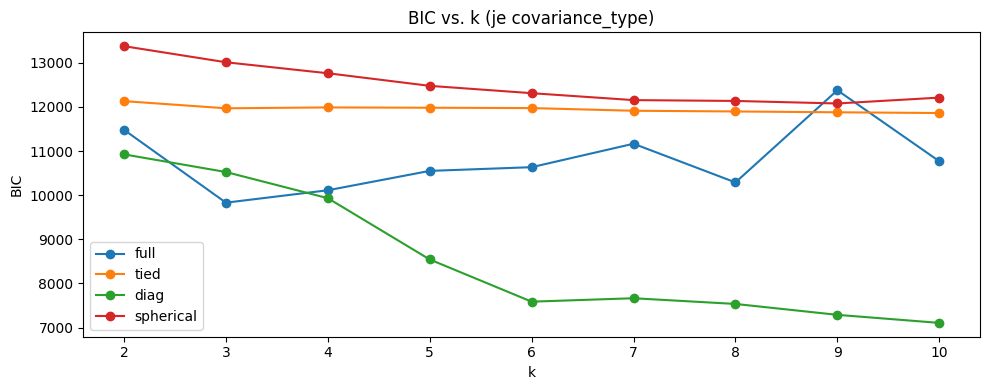

In [7]:
# BIC-Plot
plt.figure(figsize=(10,4))
for cov in cov_types:
    part = bic_df[bic_df["cov"]==cov]
    plt.plot(part["k"], part["bic"], "-o", label=cov)
plt.legend(); plt.title("BIC vs. k (je covariance_type)"); plt.xlabel("k"); plt.ylabel("BIC")
plt.tight_layout(); plt.show()

In [8]:
# K-Fold Cross-Validation für GMM
from sklearn.model_selection import KFold
import numpy as np

def gmm_cv_score(X, n_components, covariance_type, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        gm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            n_init=3,
            random_state=random_state
        )
        gm.fit(X_train)
        # mean log-likelihood je Sample 
        scores.append(gm.score(X_test))
    return float(np.mean(scores)), float(np.std(scores))

cv_rows = []
best_cv = {"score": -np.inf}
for k in K_RANGE:
    for cov in cov_types:
        mean_ll, std_ll = gmm_cv_score(X_scaled, k, cov, n_splits=5, random_state=SEED if 'SEED' in globals() else 42)
        cv_rows.append({"k": k, "covariance_type": cov, "mean_test_LL": mean_ll, "std": std_ll})
        if mean_ll > best_cv["score"]:
            best_cv = {"k": k, "cov": cov, "score": mean_ll, "std": std_ll}

import pandas as pd
df_cv = pd.DataFrame(cv_rows).sort_values(["mean_test_LL"], ascending=False).reset_index(drop=True)

# Trainieren finales Modell mit dem besten k und cov aus CV
best_k_cv, best_cov_cv = best_cv["k"], best_cv["cov"]
best_model_cv = GaussianMixture(
    n_components=best_k_cv,
    covariance_type=best_cov_cv,
    n_init=10,
    random_state=SEED if 'SEED' in globals() else 42
).fit(X_scaled)

# Namensänderung, dass es besser reinfittet in den Code
best_k, best_cov, best_model = best_k_cv, best_cov_cv, best_model_cv

print(f"[CV] Best: k={best_k_cv}, cov={best_cov_cv}, mean Test-LL={best_cv['score']:.4f} (±{best_cv['std']:.4f})")
try:
    display(df_cv.head(10))
except NameError:
    print(df_cv.head(10).to_string(index=False))


[CV] Best: k=9, cov=diag, mean Test-LL=-10.2068 (±0.9008)


,k,covariance_type,mean_test_LL,std
0,9,diag,-10.206779,0.900845
1,10,diag,-10.497571,0.724366
2,8,diag,-10.613611,0.796669
3,7,diag,-10.673245,1.267968
4,3,full,-11.252698,1.416739
5,6,diag,-11.268807,0.680080
6,5,diag,-11.734410,0.662546
7,4,diag,-12.827936,1.107188
8,3,diag,-13.598223,1.383091
9,5,full,-14.048032,1.512591


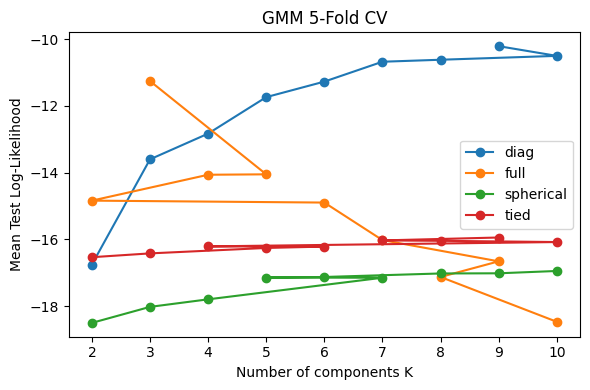

In [9]:
# Plot: K vs. Mean Test Log-Likelihood (per covariance_type)
import matplotlib.pyplot as plt

if 'df_cv' in globals():
    fig = plt.figure(figsize=(6,4))
    for cov, df_sub in df_cv.groupby('covariance_type'):
        xs = df_sub['k'].values
        ys = df_sub['mean_test_LL'].values
        plt.plot(xs, ys, marker='o', label=str(cov))
    plt.xlabel('Number of components K')
    plt.ylabel('Mean Test Log-Likelihood')
    plt.title('GMM 5-Fold CV')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("df_cv not found. Run the CV cell first.")


In [10]:
# GMM fitten
gmm = GaussianMixture(
    n_components= best_k_cv, #k_opt, # könnte man auch best_k_cv nutzen aus K-Fold
    covariance_type= best_cov_cv, #cov_opt, # oder best_cov_cv aus K-Fold
    random_state=42,
    reg_covar=1e-6,
    init_params="kmeans",
    n_init=5
).fit(X_scaled)

labels = gmm.predict(X_scaled) # hartes Label (welches Cluster)
proba  = gmm.predict_proba(X_scaled) # p(Zuordnung) je Cluster
max_p  = proba.max(axis=1)  # Sicherheit (wie nahe Spieler in seinem Cluster ist, 1=typisch, gegen 0= Grenzfall/Hybrid)

df['Cluster'] = labels
df['Cluster_p'] = max_p

In [11]:
# Zentren im Originalmaßstab
centers_scaled = gmm.means_
centers = pd.DataFrame(
    scaler.inverse_transform(centers_scaled),
    columns=X_f.columns,
    index=[f"Cluster {i}" for i in range(best_k_cv)]#k_opt)]
)
print("\nGMM-Clusterzentren (Originalmaßstab):")
print(centers.round(3))


GMM-Clusterzentren (Originalmaßstab):
           SCA90  GCA90  KP/90  PPA/90  1/3/90  CrsPA/90  PrgP/90  Int/90  \
Cluster 0  5.875  0.051  2.728   2.586   3.036     1.238    4.889   0.620   
Cluster 1  0.670  0.167  0.126   0.101   1.806    -0.000    1.826   0.802   
Cluster 2  2.714  0.311  1.094   0.756   8.274     0.171    7.109   0.898   
Cluster 3  2.418  0.361  1.183   0.678   0.670     0.206    1.355   0.226   
Cluster 4  1.490  0.000  0.533   0.348   3.306     0.000    3.632   0.812   
Cluster 5  0.272  0.000  0.000   0.055   0.396    -0.000    0.356   0.040   
Cluster 6  4.388  0.437  2.102   1.340   2.271     0.228    4.033   0.379   
Cluster 7  1.900  0.229  0.786   0.842   1.511     0.401    2.608   0.643   
Cluster 8  2.374  0.279  1.034   1.071   3.191     0.580    3.786   0.756   

           Clr/90  Touches/90  TeamSuccess+/-90  TeamSuccess(xG)xG+/-90  \
Cluster 0   1.013      66.805             0.449                   1.267   
Cluster 1   4.901      50.195           

In [12]:
# PCA für Visualisierung
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)

print("Erklärte Varianzanteile:", pca.explained_variance_ratio_)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X_f.columns
)
print(loadings)

Erklärte Varianzanteile: [0.28943166 0.19884852]
                             PC1       PC2
SCA90                   0.430501 -0.069605
GCA90                   0.181706 -0.080637
KP/90                   0.401466 -0.111460
PPA/90                  0.373681 -0.029156
1/3/90                  0.174535  0.467318
CrsPA/90                0.250648 -0.010837
PrgP/90                 0.269365  0.409269
Int/90                  0.001010  0.277460
Clr/90                 -0.190887  0.242044
Touches/90              0.162078  0.506889
TeamSuccess+/-90        0.205388  0.041686
TeamSuccess(xG)xG+/-90  0.298409  0.060244
StandardSh/90           0.264235 -0.304545
StandardSoT/90          0.226350 -0.314253


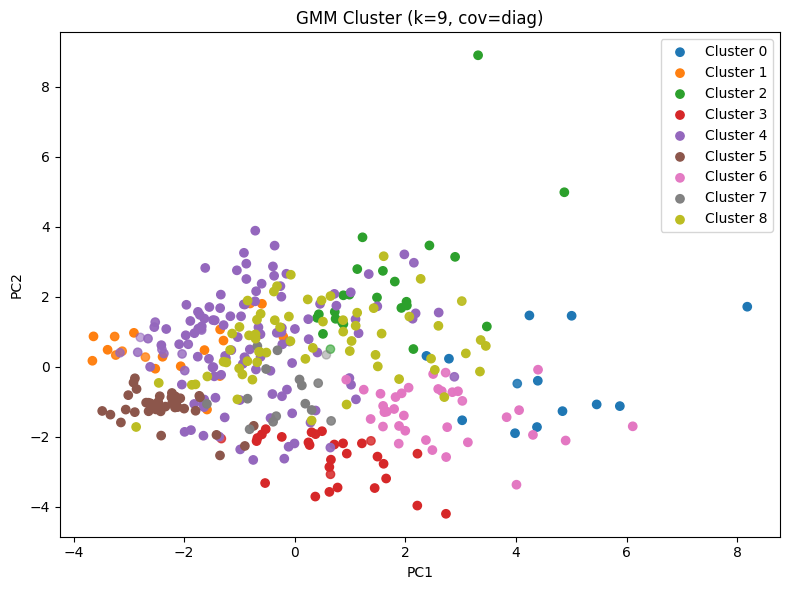

In [13]:
# PCA-Scatter mit Alpha = Sicherheit
plt.figure(figsize=(8,6))
for c in range(best_k_cv): #k_opt):
    m = (df['Cluster'] == c).values
    plt.scatter(
        pcs[m,0], pcs[m,1],
        label=f"Cluster {c}",
        alpha=np.clip(df.loc[m, 'Cluster_p'], 0.2, 1.0)
    )
plt.legend(); plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"GMM Cluster (k={best_k_cv}, cov={best_cov_cv})") #k_opt}, cov={cov_opt})")
plt.tight_layout(); plt.show()


Niedrigste Zuordnungssicherheit -> Spieler liegt zwischen Cluster:
          Player  Cluster  Cluster_p       PC1       PC2
 Jude Bellingham        7   0.448118  0.570985  0.336043
    Arlind Ajeti        4   0.570243 -2.792923  0.834791
Michel Aebischer        2   0.611000  0.644543  0.498369
  Kieran Tierney        4   0.766088 -3.159496  0.395831
   Mojmir Chytil        3   0.777983 -1.327351 -2.057827

Niedrigste Log-Likelihood -> seltene Feature Kombinationen:
        Player  Cluster  Cluster_p    loglike      PC1       PC2
 Álex Grimaldo        0   1.000000 -39.329287 8.180105  1.711213
Gonçalo Inácio        2   1.000000 -36.633246 3.313865  8.896652
   Cole Palmer        6   1.000000 -31.805191 4.397630 -0.088808
  Eberechi Eze        8   0.999854 -30.921597 0.304654 -1.540221
    Toni Kroos        2   1.000000 -29.518472 4.873239  4.981802

Größte Mahalanobis-Distanz -> größte Distanz zum eigenen Cluster: 
(Ein Feature ist auffällig, wenn es relativ zu seinem Cluster-Mittel un

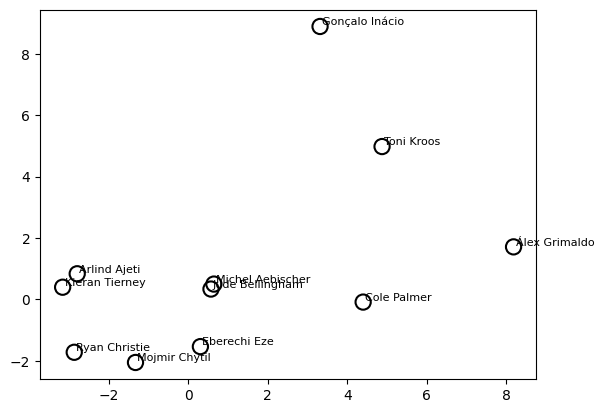

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sicherstellen, dass PC1/PC2 am df hängen
PC = pca.transform(X_scaled)[:, :2]
df["PC1"] = PC[:, 0]
df["PC2"] = PC[:, 1]

# A: niedrigste Cluster-Sicherheit (soft assignment)
suspect_conf = df.sort_values("Cluster_p").head(5)[["Player","Cluster","Cluster_p","PC1","PC2"]]

# niedrigste Log-Likelihood (am ungewöhnlichsten laut Modell)
df["loglike"] = gmm.score_samples(X_scaled)  # log p(x)
suspect_ll = df.nsmallest(5, "loglike")[["Player","Cluster","Cluster_p","loglike","PC1","PC2"]]

# größte Mahalanobis-Distanz zum eigenen Zentrum 
def mahalanobis_to_component(x, k):
    mu = gmm.means_[k]
    ctype = gmm.covariance_type
    if ctype == "diag":
        var = gmm.covariances_[k]          # 1D-Varianzen
        d = x - mu
        return float(((d**2) / var).sum())
    elif ctype == "spherical":
        var = float(gmm.covariances_[k])   # Skalar
        d = x - mu
        return float(d @ d) / var
    elif ctype == "full":
        cov = gmm.covariances_[k]
        d = x - mu
        return float(d @ np.linalg.inv(cov) @ d)
    elif ctype == "tied":
        cov = gmm.covariances_
        d = x - mu
        return float(d @ np.linalg.inv(cov) @ d)
    else:
        raise ValueError("Unknown covariance_type")

md = []
for x, k in zip(X_scaled, df["Cluster"].astype(int).to_numpy()):
    md.append(mahalanobis_to_component(x, k))
df["mdist"] = md

suspect_md = df.nlargest(5, "mdist")[["Player","Cluster","Cluster_p","mdist","PC1","PC2"]]

# Ergebnisse
print("\nNiedrigste Zuordnungssicherheit -> Spieler liegt zwischen Cluster:")
print(suspect_conf.to_string(index=False))
print("\nNiedrigste Log-Likelihood -> seltene Feature Kombinationen:")
print(suspect_ll.to_string(index=False))
print("\nGrößte Mahalanobis-Distanz -> größte Distanz zum eigenen Cluster: \n(Ein Feature ist auffällig, wenn es relativ zu seinem Cluster-Mittel und dessen Varianz stark abweicht)")

print(suspect_md.to_string(index=False))

# Punkte im PCA-Plot hervorheben aus allen drei Listen
idx_mark = set(suspect_conf.index) | set(suspect_ll.index) | set(suspect_md.index)
plt.scatter(df.loc[list(idx_mark), "PC1"], df.loc[list(idx_mark), "PC2"],
            s=120, facecolors="none", edgecolors="k", linewidths=1.5)
for i in idx_mark:
    plt.text(df.at[i,"PC1"]+0.05, df.at[i,"PC2"]+0.05, df.at[i,"Player"], fontsize=8)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

feature_df = X  
feature_names = feature_df.columns.tolist()

# Log-Likelihood je Spieler
loglike = gmm.score_samples(X_scaled)

# Mittelwerte/Varianzen (im Skalenraum) und optional Originalraum
means_k = gmm.means_                    # (K, D)
vars_k  = gmm.covariances_              # (K, D) bei cov='diag'


means_k_orig = None
X_orig = None
try:
    means_k_orig = scaler.inverse_transform(means_k)
    X_orig = scaler.inverse_transform(X_scaled)
except Exception:
    pass  # kein scaler/kein Bedarf -> einfach überspringen

def explain_point(i, feature_names, top_m=5, weighted=False):
    """
    Liefert die Top-m 'ungewöhnlichen' Features für Spieler i.
    Bei cov='diag' ist die Zerlegung je Feature eindeutig.
    """
    x = X_scaled[i]
    resp = gmm.predict_proba([x])[0]
    k = resp.argmax()

    if weighted:
        # responsibility-gewichtete Sicht über alle Komponenten
        contrib = np.sum(resp[:, None] * ((x - means_k)**2 / vars_k), axis=0)
    else:
        # Bezug zur best-passenden Komponente k
        diff = x - means_k[k]
        contrib = (diff**2) / vars_k[k]  # z^2 pro Feature

    order = np.argsort(contrib)[::-1]
    top_idx = order[:top_m]

    rows = []
    for j in top_idx:
        row = {
            "feature":        feature_names[j],
            "z2_contrib":     float(contrib[j]),
            "x_scaled":       float(x[j]),
            "mu_k_scaled":    float(means_k[k, j]),
            "cluster":        int(df.iloc[i]["Cluster"]),
            "cluster_p":      float(df.iloc[i]["Cluster_p"]),
            "loglike":        float(loglike[i]),
        }
        if X_orig is not None:
            row["x_Spieler"]    = float(X_orig[i, j])
            row["mean_Cluster"] = float(means_k_orig[k, j])
        rows.append(row)

    out = pd.DataFrame(rows)
    out.insert(0, "Player", df.iloc[i]["Player"])
    return out

# Die n Spieler mit niedrigster Log-Likelihood
n = 10
idx_outliers = np.argsort(loglike)[:n]

def print_gmm_legend():
    legend = {
        "feature":       "Betrachtetes Merkmal",
        "z2_contrib":    "Beitrag zur Ungewöhnlichkeit, Größer = auffälliger.",
        "x_scaled":      "Spielerwert im skalierten Raum.",
        "mu_k_scaled":   "Clusterzentrum (Komponente k) im skalierten Raum.",
        "x_Spieler":     "Spielerwert in Originaleinheiten.",
        "mean_Cluster":  "Clusterzentrum in Originaleinheiten.",
        "cluster":       "Hartes GMM-Label.",
        "cluster_p":     "Zuordnungssicherheit, 0 bis 1.",
        "loglike":       "Log-Likelihood unter dem gesamten GMM; größer (weniger negativ) = typischer.",
    }
    print("Erklärung:")
    for k, v in legend.items():
        print(f"  - {k:12s} {v}")

# Aufrufen:
print_gmm_legend()


tables = []
for i in idx_outliers:
    tables.append(explain_point(i, feature_names, top_m=5, weighted=False))

explanations = pd.concat(tables, ignore_index=True)
explanations





Erklärung:
  - feature      Betrachtetes Merkmal
  - z2_contrib   Beitrag zur Ungewöhnlichkeit, Größer = auffälliger.
  - x_scaled     Spielerwert im skalierten Raum.
  - mu_k_scaled  Clusterzentrum (Komponente k) im skalierten Raum.
  - x_Spieler    Spielerwert in Originaleinheiten.
  - mean_Cluster Clusterzentrum in Originaleinheiten.
  - cluster      Hartes GMM-Label.
  - cluster_p    Zuordnungssicherheit, 0 bis 1.
  - loglike      Log-Likelihood unter dem gesamten GMM; größer (weniger negativ) = typischer.


,Player,feature,z2_contrib,x_scaled,mu_k_scaled,cluster,cluster_p,loglike,x_Spieler,mean_Cluster
0,Álex Grimaldo,PPA/90,7.820664,5.965949,2.366272,0,1.000000,-39.329287,5.478261,2.586107
1,Álex Grimaldo,CrsPA/90,7.004011,8.097946,2.240520,0,1.000000,-39.329287,3.913043,1.237717
2,Álex Grimaldo,StandardSh/90,6.665892,-1.022117,0.815824,0,1.000000,-39.329287,0.000000,2.046960
3,Álex Grimaldo,Int/90,6.549308,2.564603,0.000147,0,1.000000,-39.329287,2.347826,0.620118
4,Álex Grimaldo,KP/90,5.987854,5.007477,2.012750,0,1.000000,-39.329287,5.478261,2.728134
5,Gonçalo Inácio,1/3/90,15.109646,8.393247,1.916077,2,1.000000,-36.633246,26.694915,8.274394
6,Gonçalo Inácio,PrgP/90,12.489757,6.224801,1.503337,2,1.000000,-36.633246,19.067797,7.108609
7,Gonçalo Inácio,Touches/90,8.723915,3.515531,1.362976,2,1.000000,-36.633246,124.322034,81.460887
8,Gonçalo Inácio,KP/90,3.553658,-0.958028,0.232896,2,1.000000,-36.633246,0.000000,1.093653
9,Gonçalo Inácio,PPA/90,3.242189,-0.852487,0.088851,2,1.000000,-36.633246,0.000000,0.756316


In [21]:
# Tabellarische Ausgabe, soft Clusters zu jedem Spieler
# DataFrame bauen
proba_df = pd.DataFrame(
    proba,
    columns=[f"Cluster_{i}_proba" for i in range(gmm.n_components)],
    index=df.index
)

# Hartes Label + Sicherheit
hard = proba_df.values.argmax(axis=1)
conf = proba_df.max(axis=1)

# Alles zusammen mit Name/Position
cols_keep = []
if "Player" in df.columns: cols_keep.append("Player")
if "PrimaryPosGrp" in df.columns: cols_keep.append("PrimaryPosGrp")
if "Squad" in df.columns: cols_keep.append("Squad")

out = pd.concat([df[cols_keep], proba_df], axis=1)
out["Cluster_hard"] = hard
out["Cluster_confidence"] = conf  # z.B. 0.60 = 60%

# Sortieren: erst nach Cluster, dann nach Sicherheit absteigend
out = out.sort_values(by=["Cluster_hard", "Cluster_confidence"], ascending=[True, False])
# Runden auf 8 Stellen
out = out.round(8)

# Anzeigen
print(out.head(5).to_string(index=False))

# Optional: als CSV speichern
#out.to_csv("players_gmm_soft_assignments.csv", index=False)

                 Player       Squad  Cluster_0_proba  Cluster_1_proba  Cluster_2_proba  Cluster_3_proba  Cluster_4_proba  Cluster_5_proba  Cluster_6_proba  Cluster_7_proba  Cluster_8_proba  Cluster_hard  Cluster_confidence
           Ivan Perišić  hr Croatia              1.0              0.0              0.0              0.0              0.0              0.0     0.000000e+00              0.0              0.0             0                 1.0
          Álex Grimaldo    es Spain              1.0              0.0              0.0              0.0              0.0              0.0     0.000000e+00              0.0              0.0             0                 1.0
    Francisco Conceição pt Portugal              1.0              0.0              0.0              0.0              0.0              0.0     1.000000e-08              0.0              0.0             0                 1.0
          David Jurásek  cz Czechia              1.0              0.0              0.0              0.0     

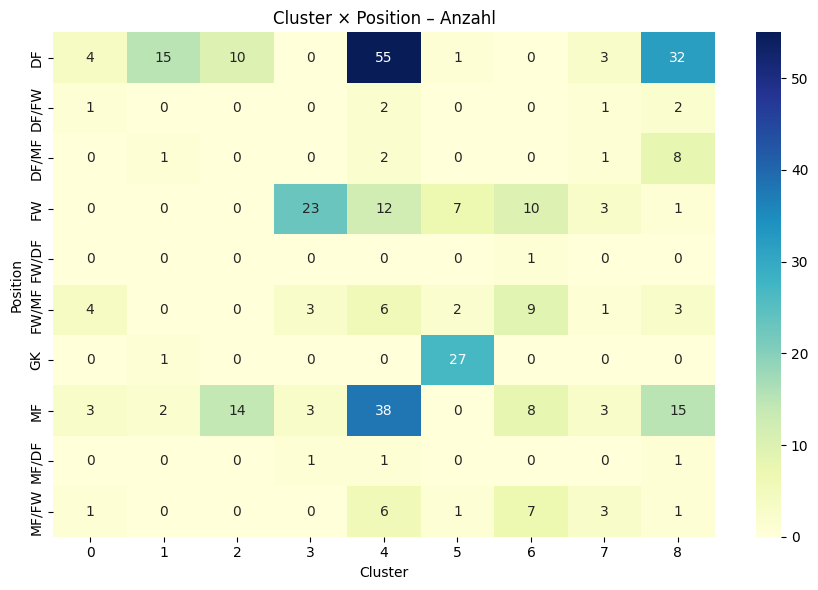

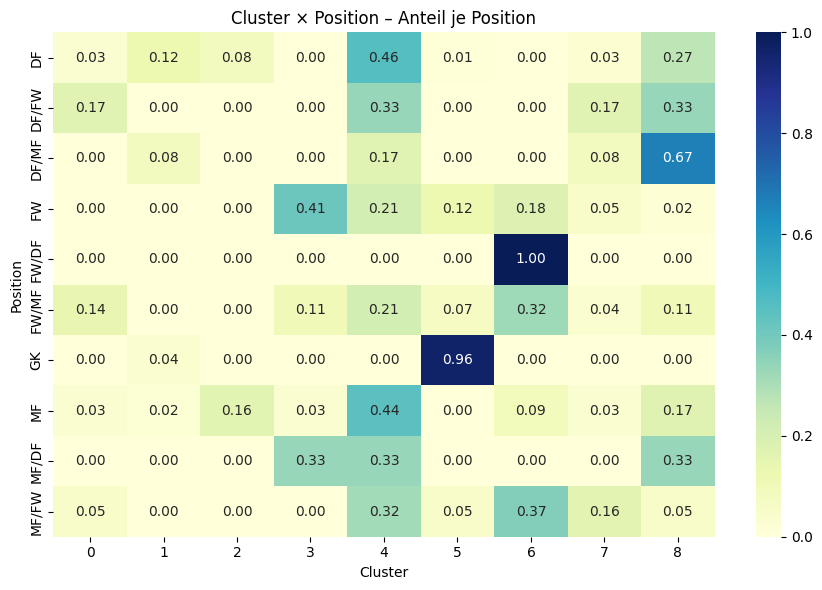

In [ ]:
# Position-Spalte finden & vereinfachen (erstes Positions-Kürzel vor Komma)
pos_col = "Position" if "Position" in df.columns else ("Pos" if "Pos" in df.columns else None)
if pos_col is None:
    raise KeyError("Keine Positionsspalte gefunden (erwarte 'Position' oder 'Pos').")

df["Pos_simple"] = df[pos_col].astype(str).str.split(",").str[0].str.strip()

# Heatmap: absolute Häufigkeiten
ct = pd.crosstab(df["Pos_simple"], df["Cluster"]).sort_index()
plt.figure(figsize=(9, 6))
sns.heatmap(ct, annot=True, fmt="g", cmap="YlGnBu")
plt.title("Cluster × Position – Anzahl")
plt.xlabel("Cluster")
plt.ylabel("Position")
plt.tight_layout()
plt.show()

# Heatmap: zeilenweise Anteile (Summe je Position = 1)
ct_row = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0)
plt.figure(figsize=(9, 6))
sns.heatmap(ct_row, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Cluster × Position – Anteil je Position")
plt.xlabel("Cluster")
plt.ylabel("Position")
plt.tight_layout()
plt.show()
